# DS 2001 Group Project

### Portfolio Simulation: top performing stocks by industries

#### Mianchen Cao, Kathy Kang, Joseph Lee

#### Operation Insturctions

1. Clean Data: removing tickers that's unreadable to yahoo finance and create a new data frame called sp500
2. Stock Operation Class: 
   This class contains five functions for individual stock operations
   1. monthly_avg: get the monthly average stock price of selected stock
   2. plot: plot the monthly average stock price
   3. reg_slope: find the regression slope of the selected stock's monthly average price against time
   4. price_change: find out how much the stock price has changed from the begin date to the final date
   5. market_cap: find out the monthly average market capitalization of the selected stock price (volume * stock price)
3. S&P Operation Class: 
   This class contains four functions for sp500 operations
   1. stock_industry_price_change: returns a data frame with columns: symbol, industry, and price change. With this data frame, we can see the stock, its industry, and its price change clearly. 
   2. stocks_and_returns_in_industry: returns the ticker and price change in the selected industry
   3. industry_index: this is a complex function. The objective of this function is to return an index that represent the whole industry. To do so, we need to calculate the monthly total market capitalization of stocks in the selected industry. Then we devide each individual stock's monthly average market capitalization with the total market capitalization to find the weight of stock. Then we multiply the weight with the stock's monthly average price. The summation of all those numbers represent the index, the price, of the industry. 
   4. top_stocks_in_industry_index: here, we find the top stocks in the selected industry. We need to call industry_index in this function because in the calculation of industry_index, we droped several stocks because yahoo finance can't return their volume values, so they don't contribute to the industry index. 
4. Industry Operation Class: 
   This class contains five functions for industry operations
   1. total_market_cap: returns the monthly average market capitalization of the selected industry
   2. stock_weight_in_industry: returns the monthly weight of each individual stock in the selected industry
   3. plot: plot the industry's index agains time
   4. price_change: find of the price change of the selected industry from the begin date to the end date
   5. all_industry_index: returns all industries' indexes
5. Top Industries: here we stored all industries' indexes into a csv file for convenience. By calculating the price change of the begin date and the end date, we ranked the industries to find the top ones. 
6. Top Stocks in Top Industries: we selected top three industries and we select the top 10 stocks in the top 3 industries, giving us 30 stocks in total, and we compose our portfolio using those 30 stocks.
7. Portfolio Operation Class: 
   There are two functions in this class
   1. portfolio_price: we used the same logic as we did with industry's index. We weighted the price of stocks in the portfolio by their market capitalization, and multiplized their monthly average return with the weight. The sum is our portfolio's price.
   2. sharpe_ratio: returns the sharpe ratio of the portfolio, the higher the sharpe ratio, the better. 
8. CAPM Class: 
   This class contains five functions for individual CAPM operations
   1. CAPM_stock: get the monthly percentage of the price of selected stock then substract risk-free rate from each row of the record and drop first row
   2. CAPM_industry: get the monthly percentage of the price of selected stock's industry then substract risk-free rate from each row of the record and drop first row
   3. CAPM_market: get the monthly percentage of the price of S&P 500 then substract risk-free rate from each row of the record and drop first row
   4. beta_sensitivity_stock_industry: calculate the beta sensitivity value between selected stock and its industry
   5. beta_sensitivity_industry_market: calculate the beta sensitivity value between selected industry and S&P 500


# Import Packages Needed

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import yfinance as yf
import pdb
import math
import scipy.stats as sp
import statsmodels.api as sm
import datetime as dt

# Clean Data

In [2]:
df = pd.read_csv('financials.csv')
df1 = df['Symbol']

In [3]:
#for i in df1: 
#    myticker = yf.Ticker(i)
#    history = myticker.history()

In [4]:
missing = ('AET', 'ALXN', 'AGN', 'ARNC', 'APC','ANDV','BHGE','BBT','BRK.B','BF.B','CHK','CA','CBG','CBS','CELG','CTL','XEC','CXO','CSRA','DWDP','DPS','ETFC','EVHC','ESRX','FLIR','GGP','HRS','HCP','JEC','LB','LUK','KORS','MYL','NFX','NBL','PCLN','RTN','RHT','COL','SCG','SNI','STI','SYMC','TIF','TWX','TMK','TSS','UTX','VAR','VIAB','HCN','WYN')

In [5]:
df = df.set_index('Symbol')
for i in missing:
    df=df.drop(index=i)
sp500 = df.reset_index()

In [6]:
tickers = sp500['Symbol']
industries = sp500['Sector'].unique()
df_industry = pd.DataFrame(industries)
df_industry.columns = (['Industries'])

In [7]:
#cleaning for S&P500
sp500index = pd.read_csv('S&P 500 Historical Data.csv')
sp500index = sp500index[["Date", "Price"]]
sp500index = sp500index.sort_index(ascending=False, axis=0)
sp500indexdf = pd.DataFrame(sp500index)
#sp500indexdf.dtypes
sp500indexdf['Price'] = sp500indexdf['Price'].apply(lambda x: float(x.split()[0].replace(',', '')))
sp500indexdf = sp500indexdf.drop(columns=['Date'])
sp500indexdf.reset_index(drop=True, inplace=True)
#type(sp500indexdf)

# Stock Operation Class

In [8]:
class Stock:
    
    def __init__ (self, ticker):
        # Stock Constructor, takes in the company ticker symbol and gets the industry that the company is in
        self.ticker = ticker
        self.industry = sp500['Sector'][sp500[sp500['Symbol'] == self.ticker].index.tolist()].tolist()[0]
    def monthly_avg(self):
        """
        PURPOSE: Get the monthly average stock price of selected stock

        OUTPUTS:
        pandas.dataframe of monthly average stock prices
        """
        history = yf.Ticker(self.ticker).history(start='2000-01-01', end='2020-12-31').reset_index()
        monthly_avg = history.groupby(pd.PeriodIndex(history['Date'], freq="M"))['Close'].mean()
        monthly_avg = pd.DataFrame(monthly_avg)
        monthly_avg.columns = ([self.ticker])
        return monthly_avg

    def plot(self):
        """
        PURPOSE: Plot the monthly average stock price
        
        INPUTS:
        none

        OUTPUTS:
        none, but displays a plot the the monthyl acerage stock price
        """
        data = self.monthly_avg()
        plot = data.plot()
    def reg_slope(self):
        """
        PURPOSE: Find the regression slope of the selected stock's monthly average price against time
        
        INPUTS:
        none

        OUTPUTS:
        the regression slope as a float
        """
        data = self.monthly_avg()
        data = data.reset_index()
        data['Month'] = range(1,len(data)+1)
        X = data['Month']
        y = data[self.ticker]
        model = sm.OLS(y, X).fit()
        predictions = model.predict(X)
        slope = model.params.values
        return slope
    def price_change(self):
        """
        PURPOSE: Find out how much the stock price has changed from the begin date to the final date
        
        INPUTS:
        none

        OUTPUTS:
        The percent change (as a decimal) of how much the closing stock price changed from 1/2001 and 12/2020
        """
        data = pd.DataFrame(self.monthly_avg())
        data = data.reset_index()
        begin = data[self.ticker][data[data['Date'] == '2000-01'].index.tolist()].tolist()
        end = data[self.ticker][data[data['Date'] == '2020-12'].index.tolist()].tolist()
        price_change = (((end[0]-begin[0]))/begin[0])
        return price_change
    def market_cap(self):
        """
        PURPOSE: Find out the monthly average market capitalization of the selected stock price (volume * stock price)
        
        INPUTS:
        none

        OUTPUTS:
        pandas.dataframe of market caps, volume, and price
        """
        history = yf.Ticker(self.ticker).history(start='2000-01-01', end='2020-12-31').reset_index()
        volume = history.groupby(pd.PeriodIndex(history['Date'], freq="M"))['Volume'].mean()
        price = self.monthly_avg()
        df_v = pd.DataFrame(volume)
        df_p = pd.DataFrame(price)
        market_cap = pd.concat([df_p, df_v], axis=1)
        market_cap['Market_Cap'] = market_cap['Volume'] * market_cap[self.ticker]
        market_cap.columns = ([self.ticker + '_' + 'Price'] , [self.ticker + '_' + 'Volume'] , [self.ticker + '_' + 'Market_Cap'])
        return market_cap

# S&P Operation Class

In [9]:
class SP500_Operation:
    def __init__ (self, df):
        # SP500 Operation constructor, takes in a dataframe of all stock ticker symbols 
        self.df = df
    def stock_industry_price_change(self):
        """
        PURPOSE: Returns a data frame with columns: symbol, industry, and price change. With this data frame, 
        we can see the stock, its industry, and its price change clearly.
        
        INPUTS:
        none

        OUTPUTS:
        pandas.dataframe of price changes in the each industry
        """
        data = []
        for i in tickers[:10]:
            try:
                stock = Stock(i)
                data.append((stock.ticker,stock.industry,stock.price_change()))
            except:
                pass
        stock_industry_price_change = pd.DataFrame(data)
        stock_industry_price_change.columns = ['Symbol', 'Industry','Price_Change']
        return stock_industry_price_change
    def stocks_and_returns_in_industry(self, industry):
        """
        PURPOSE: Returns the ticker and price change in the selected industry

        INPUTS:
        industry   string

        OUTPUTS:
        pandas.dataframe of all tickers and price changes of the selected industry
        
        """
        df = self.stock_industry_price_change()
        data = df[df['Industry']== industry]
        return data
    def industry_index(self, industry):
        """
        PURPOSE: This is a complex function. The objective of this function is to return an index that represent 
        the whole industry. To do so, we need to calculate the monthly total market capitalization of stocks in the 
        selected industry. Then we devide each individual stock's monthly average market capitalization with the total 
        market capitalization to find the weight of stock. Then we multiply the weight with the stock's monthly average 
        price. The summation of all those numbers represent the index, the price, of the industry.

        INPUTS:
        industry   string

        OUTPUTS:
        pandas.dataframe of each industry's industry index
        
        """
        A = Industry_Operation(df_industry)
        industry_market_cap, names, df = A.total_market_cap(industry)
        weight = A.stock_weight_in_industry(industry)
        #data = pd.DataFrame()
        data_list = []
        for i in names: 
            stock = Stock(i)
            price = stock.monthly_avg()
            #data[i] = price
            data_list.append(price)
        data = pd.concat(data_list, axis=1)
        a = pd.DataFrame(data.values*weight.values, columns=data.columns, index=data.index)
        Industry_Index = pd.DataFrame(a.sum(axis = 1))
        Industry_Index.columns = ([industry])
        return Industry_Index
    def top_stocks_in_industry_index(self, industry, number_stocks=0):
        """
        PURPOSE: Here, we find the top stocks in the selected industry. We need to call industry_index in this function 
        because in the calculation of industry_index, we dropped several stocks because yahoo finance can't return their 
        volume values, so they don't contribute to the industry index.

        INPUTS:
        industry          string
        number_stocks     int

        OUTPUTS:
        pandas.dataframe of all the top stocks in the selected industry
        
        """
        A = Industry_Operation(df_industry)
        industry_market_cap, names, df = A.total_market_cap(industry)
        data = []
        for i in names:
            try:
                stock = Stock(i)
                data.append((stock.ticker,stock.industry,stock.price_change()))
            except:
                pass
        df = pd.DataFrame(data)
        df.columns = ['Symbol', 'Industry','Price_Change']
        top_stocks_in_industry_index = df.nlargest(number_stocks,'Price_Change')
        return top_stocks_in_industry_index

# Industry Operation Class

In [10]:
class Industry_Operation:
    def __init__ (self, df):
        # Constructor for the Industry_Operation class, takes in a dataframe of all stock ticker symbols 
        self.df = df
    def total_market_cap(self, industry):
        """
        PURPOSE: Returns the monthly average market capitalization of the selected industry

        INPUTS:
        industry   string

        OUTPUTS:
        industry_market_cap   pandas.dataframe of the total market cap for each industry
        names                 pandas.dataframe of all ticker names
        df                    pandas.dataframe of the market cap of each companies in the selected industry
        df2                   pandas.dataframe of the stock price of each companies in the selected industry
        
        """
        stocks = sp500['Symbol'][sp500['Sector'] == industry]
        aapl = Stock('AAPL')
        df = pd.DataFrame(aapl.monthly_avg()).drop(['AAPL'], axis=1) 
        df.reset_index()
        data = pd.DataFrame()
        for i in stocks:
            stock = Stock(i)
            a = stock.market_cap()
            b = a.iloc[:,[2]]
            df = df.merge(b, how='left', on='Date')
            df = df.dropna(axis=1)
            data[industry + ' ' + 'Total Market Cap'] = df.sum(axis=1, numeric_only=True)
        industry_market_cap = pd.DataFrame(data[industry + ' ' + 'Total Market Cap'])
        columns_names = df.columns
        df2 = pd.DataFrame(aapl.monthly_avg()).drop(['AAPL'], axis=1) 
        df2.reset_index()
        data2 = pd.DataFrame()
        for i in stocks: 
            stock = Stock(i)
            a = stock.monthly_avg()
            b = a.iloc[:,0]
            df2 = df2.merge(b, how='left', on='Date')
            df2 = df2.dropna(axis=1)
        names = []
        for item in columns_names:
            name = item[0]
            tickername = name.split('_')[0]
            names.append(tickername)
        return industry_market_cap, names, df, df2
    def stock_weight_in_industry(self, industry):
        """
        PURPOSE: Returns the monthly weight of each individual stock in the selected industry

        INPUTS:
        industry   string

        OUTPUTS:
        pandas.dataframe of the weights of all the stocks in a specific industry
        
        """
        industry_market_cap, names, df, df2 = self.total_market_cap(industry)
        weight = df.div(industry_market_cap.iloc[:,0], axis=0)
        return weight 
    def plot(self, industry):
        """
        PURPOSE: Plot the industry's index over time

        INPUTS:
        industry   string

        OUTPUTS:
        none, but plots the industry index of the specified industry over time
        
        """
        A = SP500_Operation(sp500)
        data = A.industry_index(industry)
        plot = data.plot()
    def price_change(self, industry):
        """
        PURPOSE: Find of the price change of the selected industry from the begin date to the end date

        INPUTS:
        industry   string

        OUTPUTS:
        The percent change (as a decimal) of how much the industry price changed from 1/2001 and 12/2020
        
        """
        A = SP500_Operation(sp500)
        data = A.industry_index(industry)
        data = data.reset_index()
        begin = data[industry][data[data['Date'] == '2000-01'].index.tolist()].tolist()
        end = data[industry][data[data['Date'] == '2020-12'].index.tolist()].tolist()
        price_change = (((end[0]-begin[0]))/begin[0])
        return price_change
    def all_industry_index(self):
        """
        PURPOSE: Returns all industries' indexes
        
        INPUTS:
        none

        OUTPUTS:
        pandas.dataframe of the industry index for all industries
        """
        industries = self.df
        A = SP500_Operation(sp500)
        df = pd.DataFrame()
        for i in industries['Industries']:
            data = A.industry_index(i)
            df[i] = data
        return df

In [11]:
# This section is to get all monthly historical price change data into csv to speed up the code
A = Industry_Operation(df_industry)
#all_indusry_index = A.all_industry_index()
#all_indusry_index.to_csv('all_indusry_index.csv')

# Top Industries

<AxesSubplot:>

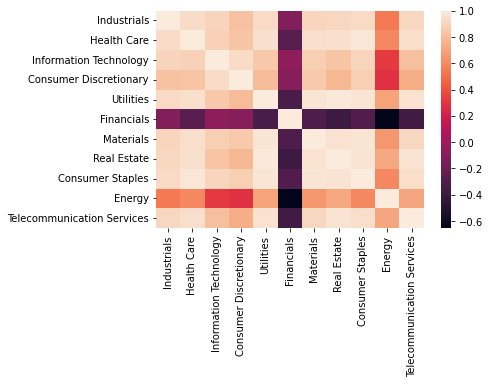

In [12]:
all_indusry_index = pd.read_csv('all_indusry_index.csv').set_index('Date')
sns.heatmap(data = all_indusry_index.corr())

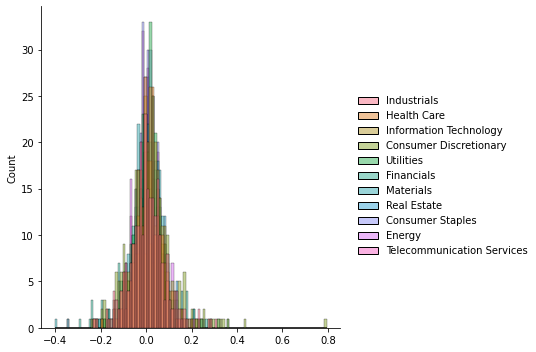

In [13]:
sns.displot(data=all_indusry_index.pct_change())

<AxesSubplot:ylabel='Density'>

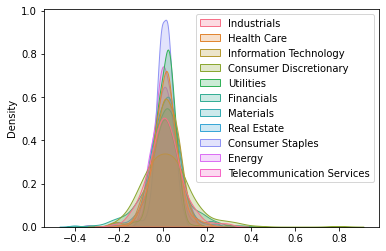

In [14]:
sns.kdeplot(data=all_indusry_index.pct_change(),shade = True)

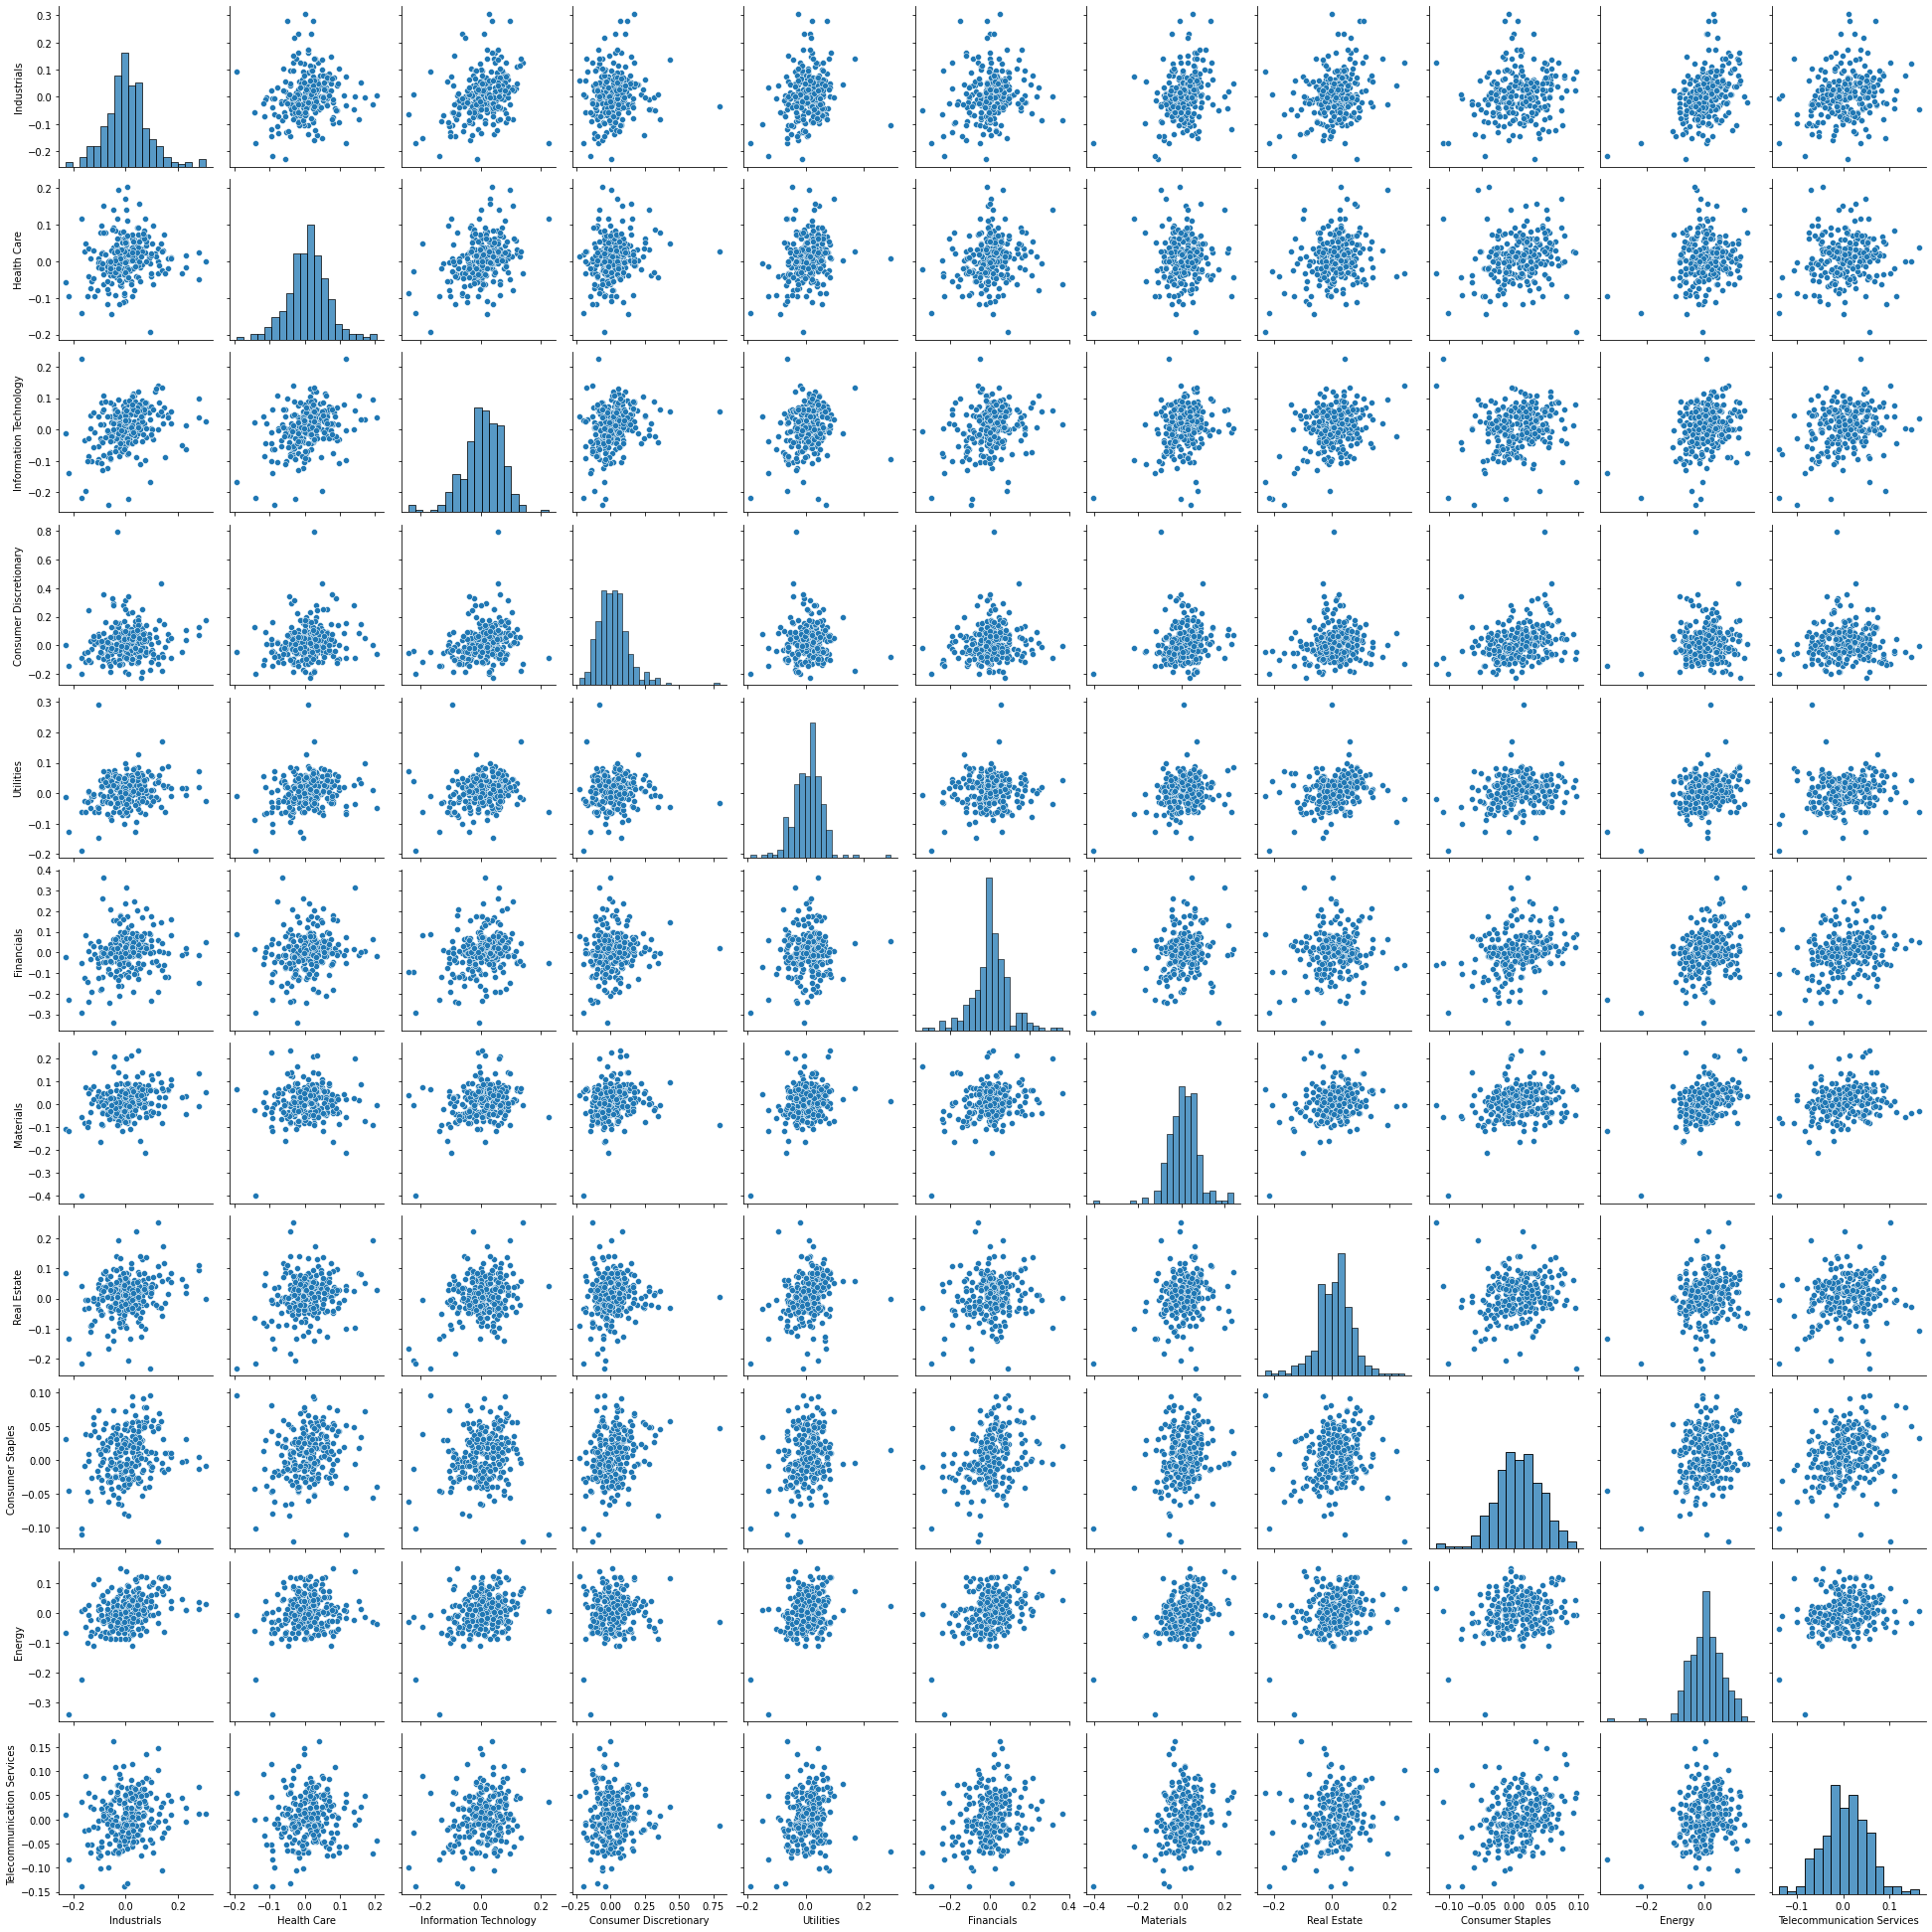

In [15]:
sns.pairplot(data=all_indusry_index.pct_change())

<AxesSubplot:xlabel='Date'>

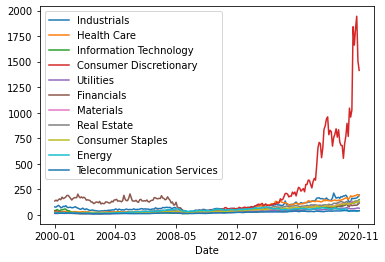

In [16]:
all_indusry_index.plot()

#### List of the Top Performing Industries

In [17]:
begin = all_indusry_index.iloc[0,:]
end = all_indusry_index.iloc[-1,:]
pct_change = ((end-begin)/begin)*100
top_industries = pd.DataFrame(pct_change.nlargest(11))
top_industries = top_industries.reset_index()
top_industries.columns = (['Industry','Percentage_Change'])
top_industries

Industry  Percentage_Change
0       Consumer Discretionary        3746.283120
1                    Materials         634.964079
2                  Real Estate         507.016591
3                  Health Care         494.301341
4             Consumer Staples         413.800276
5                    Utilities         364.587023
6       Information Technology         252.824411
7                       Energy         150.359789
8                  Industrials         150.100570
9   Telecommunication Services         146.599392
10                  Financials         -14.262011

# Top Stocks in Top Industries

In [18]:
A = Industry_Operation(df_industry)
industry_market_cap, names, df, df2 = A.total_market_cap('Consumer Discretionary')
Consumer_Discretionary = df2
industry_market_cap, names, df, df2 = A.total_market_cap('Materials')
Materials = df2
industry_market_cap, names, df, df2 = A.total_market_cap('Real Estate')
Real_Estate = df2

begin = Consumer_Discretionary.iloc[0,:]
end = Consumer_Discretionary.iloc[-1,:]
pct_change = (end-begin)/begin
top_stocks_Consumer_Discretionary = pd.DataFrame(pct_change.nlargest(10))
top_stocks_Consumer_Discretionary = top_stocks_Consumer_Discretionary.reset_index()
top_stocks_Consumer_Discretionary.columns = (['Stock','Percentage_Change'])

begin = Materials.iloc[0,:]
end = Materials.iloc[-1,:]
pct_change = (end-begin)/begin
top_stocks_Materials = pd.DataFrame(pct_change.nlargest(10))
top_stocks_Materials = top_stocks_Materials.reset_index()
top_stocks_Materials.columns = (['Stock','Percentage_Change'])

begin = Real_Estate.iloc[0,:]
end = Real_Estate.iloc[-1,:]
pct_change = (end-begin)/begin
top_stocks_Real_Estate = pd.DataFrame(pct_change.nlargest(10))
top_stocks_Real_Estate = top_stocks_Real_Estate.reset_index()
top_stocks_Real_Estate.columns = (['Stock','Percentage_Change'])

top_Real_Estate_returns = Real_Estate[top_stocks_Real_Estate['Stock']]
top_Materials_returns = Materials[top_stocks_Materials['Stock']]
top_Consumer_Discretionary_returns = Consumer_Discretionary[top_stocks_Consumer_Discretionary['Stock']]

all_my_stocks = top_Consumer_Discretionary_returns.merge(top_Materials_returns, how='left', on='Date')
all_my_stocks = all_my_stocks.merge(top_Real_Estate_returns, how='left', on='Date')
all_my_stocks

- MON: Data doesn't exist for startDate = 946702800, endDate = 1609390800
- MON: Data doesn't exist for startDate = 946702800, endDate = 1609390800
- PX: Data doesn't exist for startDate = 946702800, endDate = 1609390800
- PX: Data doesn't exist for startDate = 946702800, endDate = 1609390800
- MON: Data doesn't exist for startDate = 946702800, endDate = 1609390800
- PX: Data doesn't exist for startDate = 946702800, endDate = 1609390800


TSCO         KMX        ROST        ORLY         AMZN  \
Date                                                                   
2000-01    0.863387    0.960938    1.437120    7.774219    68.050000   
2000-02    0.925120    0.806250    1.449323    6.254688    72.462500   
2000-03    1.031696    1.279891    1.981065    6.529891    66.698370   
2000-04    1.097273    1.372533    2.256287    6.759868    56.375000   
2000-05    0.945307    1.281250    2.179199    7.078125    53.693892   
...             ...         ...         ...         ...          ...   
2020-08  147.775826  104.526191   90.361609  464.841428  3249.254755   
2020-09  138.848934  102.048572   91.286869  464.976190  3160.748105   
2020-10  142.115351   91.967727   93.171410  456.674090  3230.600419   
2020-11  132.069395   94.147001  104.062251  450.909499  3141.807996   
2020-12  139.877773   95.280000  114.705372  450.511902  3194.931908   

                 AZO        SBUX        TJX         NKE        DHI  ...  \
Date                                                                ...   
2000-01    29.043750    2.696336   1.809907    4.867936   2.489840  ...   
2000-02    23.953125    3.469426   1.585261    3.406191   2.462598  ...   
2000-03    24.149457    3.808400   1.800892    3.205463   2.606163  ...   
2000-04    26.562500    3.895112   2.059988    4.255666   2.702286  ...   
2000-05    25.107955    3.274029   1.920622    4.258118   2.791248  ...   
...              ...         ...        ...         ...        ...  ...   
2020-08  1196.049061   77.220253  54.064336  105.461957  71.018328  ...   
2020-09  1198.472860   83.829084  54.192431  117.566779  71.508359  ...   
2020-10  1160.573187   86.832909  55.161714  126.731064  73.887905  ...   
2020-11  1143.627509   93.254908  58.738731  129.216471  72.347163  ...   
2020-12  1167.923811  100.910455  65.696539  138.409467  70.782093  ...   

               VTR         PSA          O         MAA         ESS         ARE  \
Date                                                                            
2000-01   1.242210   10.588226   3.030279    7.102162   14.813267   14.089970   
2000-02   1.104972   10.178924   3.039394    7.158929   15.152638   13.831157   
2000-03   1.056491    9.777351   2.973686    7.205137   15.747631   14.352418   
2000-04   1.192870   10.206515   3.013946    7.604505   16.708476   14.959158   
2000-05   1.258631   10.255310   3.311826    7.780643   17.875520   15.998435   
...            ...         ...        ...         ...         ...         ...   
2020-08  39.001900  194.722555  56.795361  112.099967  208.742491  167.095434   
2020-09  41.277658  210.928921  57.704943  112.404644  204.407850  156.918335   
2020-10  41.184360  225.520821  56.328016  116.648061  199.107965  157.018714   
2020-11  45.416445  222.281126  56.877048  123.113596  239.176566  157.319170   
2020-12  47.621461  220.213744  56.634224  120.654750  235.143527  168.875778   

               UDR        SBAC         PLD         AVB  
Date                                                    
2000-01   3.170918   24.463359    8.526843   14.406628  
2000-02   3.193745   33.438173    8.670018   14.139385  
2000-03   3.137559   46.210615    8.800282   14.471012  
2000-04   3.253285   38.904499    9.357137   15.800031  
2000-05   3.465768   40.646570    9.784463   16.872098  
...            ...         ...         ...         ...  
2020-08  33.573252  301.425454  100.264515  147.157173  
2020-09  32.417977  307.505782   97.586667  146.399312  
2020-10  32.158131  304.774988  101.205102  144.984869  
2020-11  36.677901  291.910048   99.692509  159.158392  
2020-12  37.233455  276.372377   96.079895  157.878543  

[252 rows x 30 columns]

In [19]:
# This part is to save our created top performing stocks by industries into csv file
#all_my_stocks.to_csv('all_my_stocks.csv')

<AxesSubplot:>

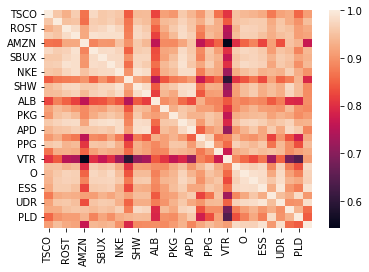

In [20]:
sns.heatmap(all_my_stocks.corr())

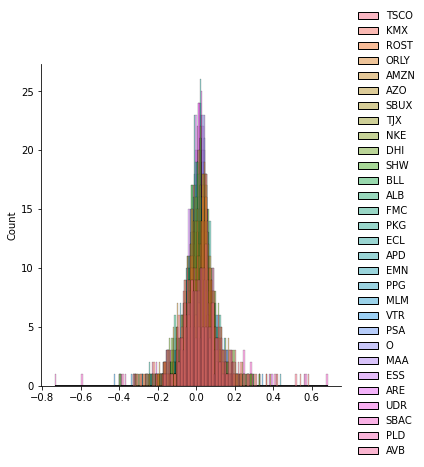

In [21]:
sns.displot(data=all_my_stocks.pct_change())

<AxesSubplot:ylabel='Density'>

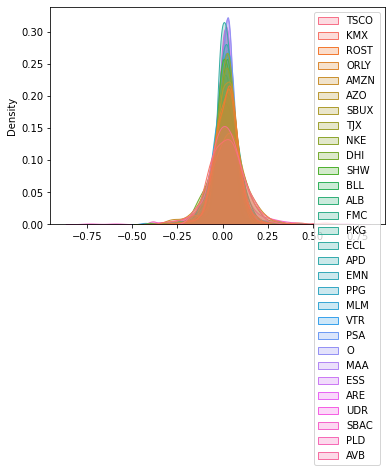

In [22]:
sns.kdeplot(data=all_my_stocks.pct_change(),shade = True)

<AxesSubplot:xlabel='Date'>

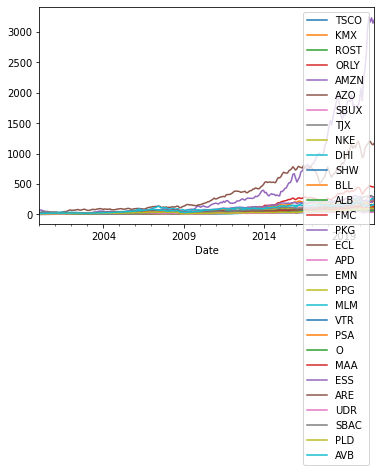

In [23]:
all_my_stocks.plot()

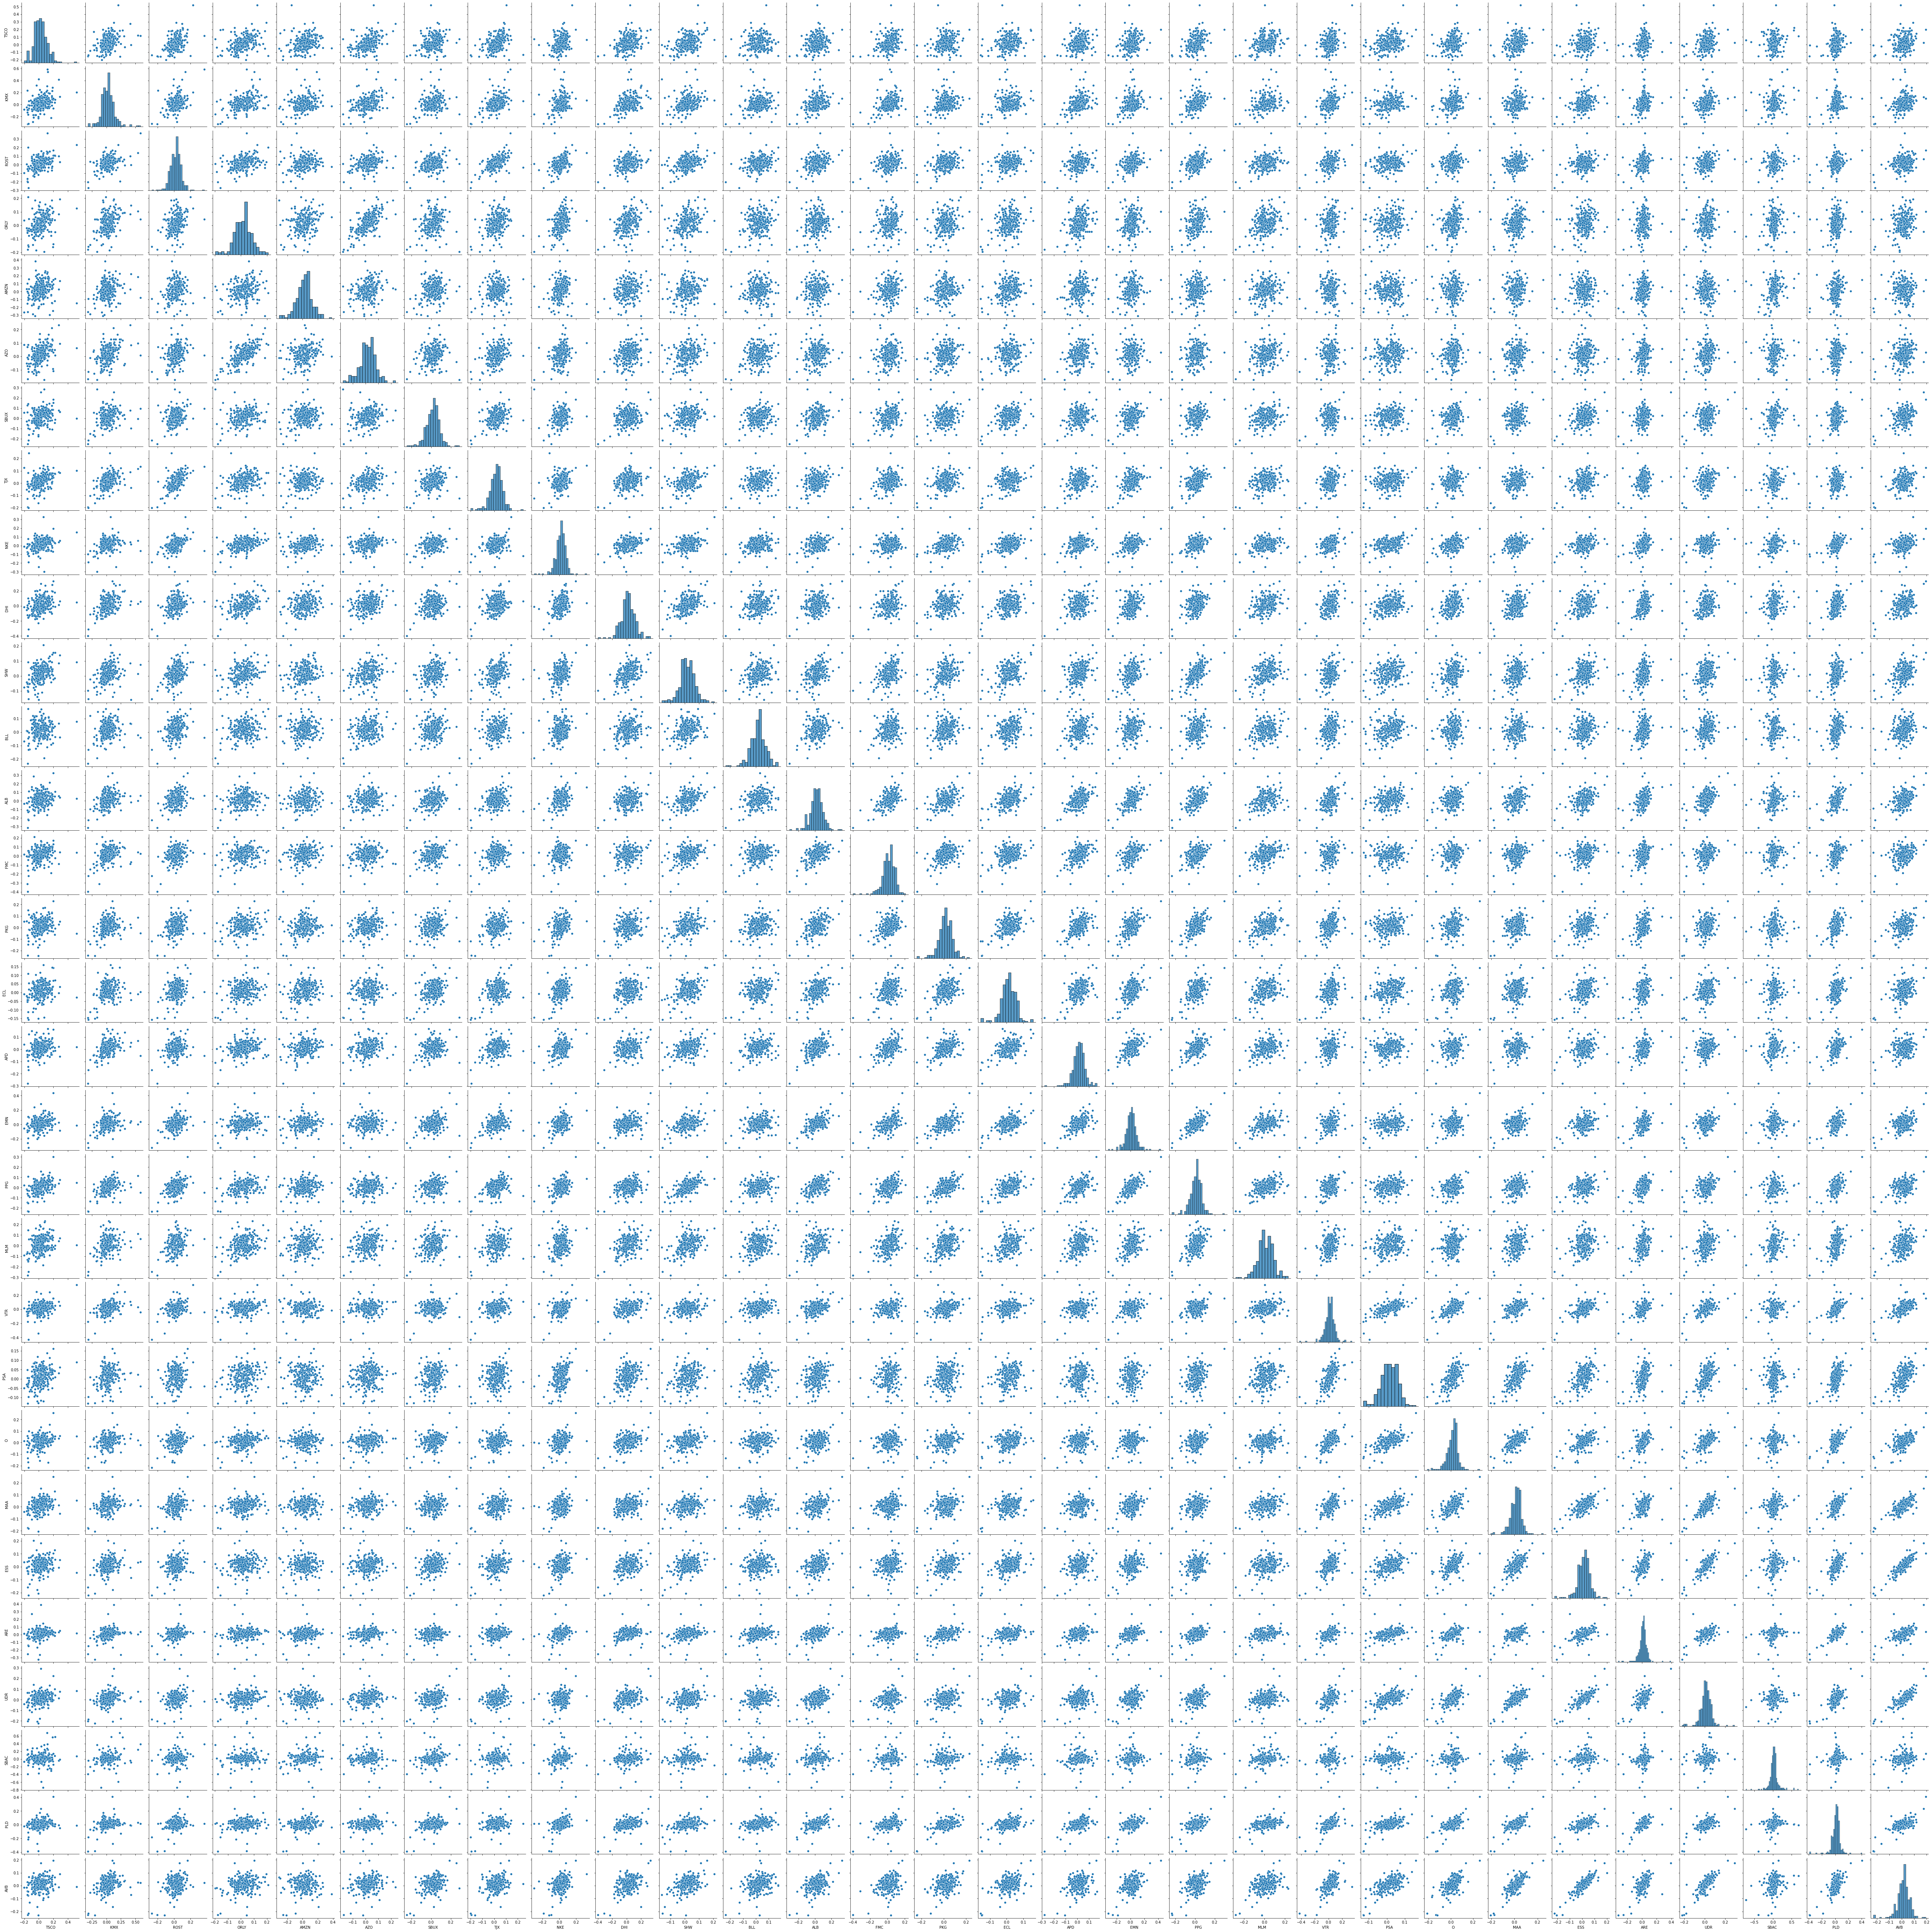

In [24]:
sns.pairplot(data=all_my_stocks.pct_change())

# Portfolio Operation Class

In [25]:
class Portfolio_Operation:
    def __init__(self, df):
        # Constructor for the Portfolio_Operation class, takes in a dataframe of all stock ticker symbols 
        self.df = df
    def portfolio_price(self):
        """
        PURPOSE: We used the same logic as we did with industry's index. We weighed the price of stocks in the portfolio 
        by their market capitalization and multiplied their monthly average return with the weight. The sum is our 
        portfolio's price.
        
        INPUTS:
        none

        OUTPUTS:
        The price of the portfolio as a float
        """
        aapl = Stock('AAPL')
        df = pd.DataFrame(aapl.monthly_avg()).drop(['AAPL'], axis=1) 
        df.reset_index()
        df2 = pd.DataFrame(aapl.monthly_avg()).drop(['AAPL'], axis=1) 
        df2.reset_index()
        for i in self.df.columns: 
            stock = Stock(i)
            a = stock.market_cap()
            df = df.merge(a.iloc[:,2], how = 'left', on='Date')
        total_market_cap = pd.DataFrame(df.sum(axis=1))
        weight = df.div(total_market_cap.iloc[:,0], axis=0) 
        for i in self.df.columns: 
            stock = Stock(i)
            a = stock.monthly_avg()
            df2 = df2.merge(a, how = 'left', on = 'Date')
        weighted_price = pd.DataFrame(df2.values*weight.values, columns=df2.columns, index=df2.index)
        portfolio_price = pd.DataFrame(weighted_price.sum(axis=1))
        portfolio_price.columns = (['My Portfolio Price'])
        return portfolio_price
    def sharpe_ratio(self):
        """
        PURPOSE: Returns the sharpe ratio of the portfolio, the higher the sharpe ratio, the better.
        
        INPUTS:
        none

        OUTPUTS:
        The sharpe ratio of the portfolio as a float
        """
        A = Portfolio_Operation(all_my_stocks)
        a = A.portfolio_price()
        sharpe = ((a.pct_change().mean()-0.00148)/a.pct_change().std())*(252**0.5)
        return sharpe

In [26]:
A = Portfolio_Operation(all_my_stocks)
a = A.portfolio_price() 
a
#This part is to save created portfolio into csv file
#a.to_csv('My_Portfolio_Price.csv')

My Portfolio Price
Date                       
2000-01           51.153313
2000-02           54.248239
2000-03           43.749925
2000-04           36.893843
2000-05           35.033498
...                     ...
2020-08         2368.271231
2020-09         2360.679615
2020-10         2495.131770
2020-11         2183.847737
2020-12         2138.054529

[252 rows x 1 columns]

#### Sharpe Ratio

In [25]:
A.sharpe_ratio()

My Portfolio Price    2.662523
dtype: float64

# CAPM 

 
\begin{aligned} &E[R_i] - R_f  = \beta_i ( E[R_m] - R_f ) \\ \\ &\textbf{where:} \\ &ER_i = \text{expected return of stock i} \\ &R_f = \text{risk-free rate} \\ &\beta_i = \text{beta of the stock} \\ &ER_m - R_f = \text{market risk premium} \\ \end{aligned} 


In [27]:
R_f = 0.015
industrydata = pd.read_csv('all_indusry_index.csv')
class CAPM:
    """CAPM_stock: get the monthly percentage of the price of selected stock then substract risk-free rate from each row of the record and drop first row
CAPM_industry: get the monthly percentage of the price of selected stock's industry then substract risk-free rate from each row of the record and drop first row
CAPM_market: get the monthly percentage of the price of S&P 500 then substract risk-free rate from each row of the record and drop first row
beta_sensitivity_stock_industry: calculate the beta sensitivity value between selected stock and its industry
beta_sensitivity_industry_market: calculate the beta sensitivity value between selected industry and S&P 500
"""
    def __init__(self,stock):
        # Constructor for the CAPM class, takes in a stock
        self.stock = stock
        self.industry = sp500['Sector'][sp500[sp500['Symbol'] == self.stock].index.tolist()].tolist()[0]
        self.market = sp500indexdf
    def CAPM_stock(self, stock):
        """
        PURPOSE: Get the monthly percentage of the price of selected stock then substract risk-free rate from each row of 
        the record and drop first row

        INPUTS:
        stock          string

        OUTPUTS:
        pcch           series (one-dimensional labeled array)
        
        """
        #this is stock monthly percent change
        s = Stock(stock)
        a = s.monthly_avg()
        a = pd.DataFrame(a)
        a.columns=([stock])
        pch = a.pct_change()
        pcch = pch-R_f
        pcch = pcch.iloc[1:]
        pcch.reset_index(drop=True, inplace=True)
        #pcch = pcch.drop('Date', axis=1, inplace=True)
        return pcch
    def CAPM_industry(self, industry):
        """
        PURPOSE: Get the monthly percentage of the price of selected stock's industry then substract risk-free rate from each 
        row of the record and drop first row

        INPUTS:
        industry          string

        OUTPUTS:
        idata             series (one-dimensional labeled array)
        
        """
        indus = sp500['Sector'][sp500[sp500['Symbol'] == self.stock].index.tolist()].tolist()[0]
        i = industrydata
        i = i[indus]
        idata = pd.DataFrame(i)
        idata = idata.pct_change()
        idata = idata - R_f
        idata = idata.iloc[1:]
        idata.reset_index(drop=True, inplace=True)
        return idata
    def CAPM_market(self, market):
        """
        PURPOSE: Get the monthly percentage of the price of S&P 500 then substract risk-free rate from each row of the 
        record and drop first row

        INPUTS:
        pandas.dataframe           

        OUTPUTS:
        sp500_return      series (one-dimensional labeled array)
        
        """
        #This returns market return - R_f
        sp500_return = sp500indexdf['Price'].pct_change()
        sp500_return = sp500_return-R_f
        sp500_return = sp500_return.iloc[1:]
        sp500_return.reset_index(drop=True, inplace=True)
        return sp500_return
    def beta_sensitivity_stock_industry(self, ticker_rtn, indus_rtn):
        """
        PURPOSE: Calculate the beta sensitivity value between selected stock and its industry

        INPUTS:
        ticker_rtn        series (one-dimensional labeled array)
        indus_rtn         series (one-dimensional labeled array)

        OUTPUTS:
        betaEst[0]        float
        
        """
        ticker_m_rtn = np.array(ticker_rtn)
        indus_m_rtn = np.array(indus_rtn)
        ind_rtn_trans = np.transpose(indus_m_rtn)
        ind_rtn_mul = np.matmul(ind_rtn_trans, indus_m_rtn)
        ind_inv = np.reciprocal(ind_rtn_mul)
        ind_inv_mul_appl = np.matmul(ind_rtn_trans, ticker_m_rtn)
        betaEst = np.multiply(ind_inv, ind_inv_mul_appl)
        return betaEst[0]
    def beta_sensitivity_industry_market(self, indus_rtn, market_rtn):
        """
        PURPOSE: Calculate the beta sensitivity value between selected industry and S&P 500

        INPUTS:
        industry          series (one-dimensional labeled array)
        number_stocks     series (one-dimensional labeled array)

        OUTPUTS:
        betaEst           float
        
        """
        indus_m_rtn = np.array(indus_rtn)
        market_m_rtn = np.array(market_rtn)
        sp500_rtn_trans = np.transpose(market_m_rtn)
        sp500_rtn_mul = np.matmul(sp500_rtn_trans, market_m_rtn)
        sp500_inv = np.reciprocal(sp500_rtn_mul)
        sp500_inv_mul_appl = np.matmul(sp500_rtn_trans, indus_m_rtn)
        betaEst = np.multiply(sp500_inv, sp500_inv_mul_appl)
        return betaEst

### Calculating Beta Sensitivities of the Portfolio

In [28]:
myStocks = pd.read_csv('all_my_stocks.csv')
myStocks = myStocks.drop(columns = ["Date"])
myStocks
stockN = []
for col in myStocks.columns:
    stockN.append(col)
betaRes1 = []
betaRes2 = []
for col in stockN:
    
    stock = CAPM(col)
    stockReturn = stock.CAPM_stock(stock.stock)
    stock_ind_return = stock.CAPM_industry(stock.industry)
    sp500return = stock.CAPM_market(stock.market)
    beta1 = stock.beta_sensitivity_stock_industry(stockReturn, stock_ind_return)
    beta2 = stock.beta_sensitivity_industry_market(stock_ind_return, sp500return)
    betaRes1.append(beta1)
    betaRes2.append(beta2)

tempdf = pd.DataFrame(betaRes1)
tempdf2 = pd.DataFrame(betaRes2)

In [29]:
tempdf
tempdf2
name = pd.DataFrame(stockN)
tempresult = pd.concat([tempdf, tempdf2], axis=1, join='inner')
portfolioBeta = pd.concat([name, tempresult], axis=1, join='inner')
portfolioBeta.columns =['Ticker', 'Beta between Stock and Industry', 'Beta between Industry and Market']
portfolioBeta

Ticker  Beta between Stock and Industry  Beta between Industry and Market
0    TSCO                         0.140640                          0.467528
1     KMX                         0.119678                          0.467528
2    ROST                         0.016002                          0.467528
3    ORLY                         0.070727                          0.467528
4    AMZN                         0.441014                          0.467528
5     AZO                         0.086856                          0.467528
6    SBUX                         0.041497                          0.467528
7     TJX                         0.023990                          0.467528
8     NKE                         0.102030                          0.467528
9     DHI                         0.112860                          0.467528
10    SHW                         0.197957                          0.451969
11    BLL                         0.303617                          0.451969
12    ALB                         0.468734                          0.451969
13    FMC                         0.495431                          0.451969
14    PKG                         0.380598                          0.451969
15    ECL                         0.254281                          0.451969
16    APD                         0.340213                          0.451969
17    EMN                         0.486908                          0.451969
18    PPG                         0.374499                          0.451969
19    MLM                         0.469097                          0.451969
20    VTR                         0.347417                          0.412121
21    PSA                         0.328219                          0.412121
22      O                         0.315804                          0.412121
23    MAA                         0.320132                          0.412121
24    ESS                         0.356700                          0.412121
25    ARE                         0.405800                          0.412121
26    UDR                         0.387274                          0.412121
27   SBAC                         0.744141                          0.412121
28    PLD                         0.495626                          0.412121
29    AVB                         0.383971                          0.412121

In [30]:
myPortfolio = pd.read_csv('My_Portfolio_Price.csv')
myPortfolio = myPortfolio.drop(columns=["Date"])
preturn = myPortfolio["My Portfolio Price"].pct_change()
preturn = preturn.iloc[1:]
preturn = preturn-R_f
sn = sp500indexdf['Price'].pct_change()
sn = sn-R_f
mreturn = sn.iloc[1:]
#sn.reset_index(drop=True, inplace=True)
mreturn
p_rtn_trans = np.transpose(preturn)
p_rtn_mul = np.matmul(p_rtn_trans, preturn)
p_inv = np.reciprocal(p_rtn_mul)
p_inv_mul_m = np.matmul(p_rtn_trans, mreturn)
betaEst = np.multiply(p_inv, p_inv_mul_m)
betaEst
print("Beta estimate of our portfolio is ", betaEst)


Beta estimate of our portfolio is  0.07295487610522018


# Stock Unit Testing

In [31]:
import unittest

# Tests the Stock class
class TestStock(unittest.TestCase):
    aapl = Stock('AAPL')
    def test_monthly_avg(self):
        avg = self.aapl.monthly_avg()
        self.assertEqual(str(type(avg)), "<class 'pandas.core.frame.DataFrame'>")
    
    def test_price_change(self):
        change = self.aapl.price_change()
        self.assertEqual(round(change, 4), 158.5699)
    
    def test_reg_slope(self):
        slope = self.aapl.reg_slope()
        self.assertEqual(round(slope[0], 4), 0.1694)
        
    def test_market_cap(self):
        avg = self.aapl.monthly_avg()
        self.assertEqual(str(type(avg)), "<class 'pandas.core.frame.DataFrame'>")



# CAPM Unit Testing

In [32]:
# Tests the CAPM class
class TestCAPM(unittest.TestCase):
    apple = CAPM('AAPL')
    def test_capm_stock_indus(self):
        apple = CAPM('AAPL')
        applreturn = apple.CAPM_stock(apple.stock)
        apple_ind_return = apple.CAPM_industry(apple.industry)
        beta = self.apple.beta_sensitivity_stock_industry(applreturn, apple_ind_return)
        self.assertEqual(round(beta[0], 5), 0.48876)
    def test_capm_indus_market(self):
        apple = CAPM('AAPL')
        apple_ind_return = apple.CAPM_industry(apple.industry)
        sp500return = apple.CAPM_market(apple.market)
        beta = self.apple.beta_sensitivity_industry_market(apple_ind_return, sp500return)
        self.assertEqual(round(beta[0], 8), 0.70389467)

unittest.main(argv=[''], verbosity=2, exit=False)


test_capm_indus_market (__main__.TestCAPM) ... ok
test_capm_stock_indus (__main__.TestCAPM) ... ok
test_market_cap (__main__.TestStock) ... ok
test_monthly_avg (__main__.TestStock) ... ok
test_price_change (__main__.TestStock) ... ok
test_reg_slope (__main__.TestStock) ... ok

----------------------------------------------------------------------
Ran 6 tests in 1.266s

OK
